# BiLSTM 多分类模型训练

用于抗性基因(ARG)类别分类

**关键改进**:
1. Focal Loss 处理类别不平衡
2. 分层采样确保每个batch包含各类样本
3. 自动合并稀有类别
4. 保存配置信息到模型文件


In [11]:
import os
import time
import random
import logging
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader


## 1. 配置参数


In [12]:
# ================== 模型配置（预测时必须保持一致）==================
MODEL_CONFIG = {
    'embedding_size': 21,    # One-hot编码维度 (20氨基酸 + PAD)
    'hidden_size': 128,      # LSTM隐藏层维度
    'num_layers': 2,         # LSTM层数
    'dropout': 0.4,          # 降低Dropout，防止欠拟合
}

# ================== 训练配置 ==================
TRAIN_CONFIG = {
    'batch_size': 256,       # 增大batch size，让loss更平滑
    'lr': 0.002,             # 稍微提高初始学习率
    'warmup_epochs': 5,      # 学习率预热轮数
    'epochs': 150,
    'patience': 25,          # 增加早停耐心值
    'min_samples': 50,       # 少于此数的类别合并为Others
    'focal_gamma': 0.5,      # 降低gamma，减少对困难样本的过度关注
    'label_smoothing': 0.1,  # 标签平滑，让训练更稳定
}

# ================== 路径配置（请修改为实际路径）==================
PATH_CONFIG = {
    # 说明：notebook 的相对路径会受当前工作目录影响（在根目录执行/在 notebook 目录执行会不同）。
    # 这里做一个“向上查找 data/ 目录”的自动解析，减少路径踩坑。
    'fasta_file': "ARG_db_all_seq_uniq_representative_rename_2_repsent.fasta",  # ARG 序列文件名（实际路径会自动解析到 repo_root/data/ 下）
    'save_dir': "./well-trained",
    'log_dir': "./logs",
    'fig_dir': "./figures",
}

from pathlib import Path

def resolve_repo_data_file(filename: str) -> str:
    cwd = Path.cwd().resolve()
    for p in [cwd] + list(cwd.parents):
        cand = p / 'data' / filename
        if cand.is_file():
            return str(cand)
    # fallback：按当前工作目录的相对路径尝试一次
    cand = (cwd / filename)
    if cand.is_file():
        return str(cand)
    raise FileNotFoundError(f"无法找到数据文件：{filename}（已从 {cwd} 向上查找 data/ 目录）")

PATH_CONFIG['fasta_file'] = resolve_repo_data_file(PATH_CONFIG['fasta_file'])
assert os.path.exists(PATH_CONFIG['fasta_file']), (
    f"FASTA 文件不存在：{PATH_CONFIG['fasta_file']}（请检查工作目录或修改 PATH_CONFIG）"
)

# 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 随机种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 创建目录
for d in [PATH_CONFIG['save_dir'], PATH_CONFIG['log_dir'], PATH_CONFIG['fig_dir']]:
    os.makedirs(d, exist_ok=True)

# 日志
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
logger = logging.getLogger()


Using device: cuda:0


## 2. 数据处理


In [13]:
# 氨基酸编码字典
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
AA_DICT = {aa: i for i, aa in enumerate(AMINO_ACIDS)}
AA_DICT.update({
    'B': [AA_DICT['D'], AA_DICT['N']],  # Asp or Asn
    'Z': [AA_DICT['E'], AA_DICT['Q']],  # Glu or Gln
    'J': [AA_DICT['I'], AA_DICT['L']],  # Ile or Leu
    'X': 'ANY',
    'PAD': 20
})

def one_hot_encode(sequence, max_length):
    """将氨基酸序列转换为one-hot编码"""
    encoding = np.zeros((max_length, 21), dtype=np.float32)
    for i in range(min(len(sequence), max_length)):
        aa = sequence[i]
        if aa in AA_DICT:
            idx = AA_DICT[aa]
            if isinstance(idx, list):  # 模糊氨基酸
                for j in idx:
                    encoding[i, j] = 0.5
            elif idx == 'ANY':  # 未知氨基酸
                encoding[i, :20] = 0.05
            else:
                encoding[i, idx] = 1.0
        else:
            encoding[i, :20] = 0.05  # 未知字符
    # 填充位置标记为PAD
    if len(sequence) < max_length:
        encoding[len(sequence):, 20] = 1.0
    return encoding


class ARGDataset(Dataset):
    """ARG序列数据集"""
    def __init__(self, sequences, labels, max_length):
        self.sequences = sequences
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        encoded = one_hot_encode(self.sequences[idx], self.max_length)
        return torch.from_numpy(encoded), torch.tensor(self.labels[idx], dtype=torch.long)


## 3. 模型定义


In [14]:
class FocalLoss(nn.Module):
    """Focal Loss with Label Smoothing for imbalanced classification"""
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.0):
        super().__init__()
        self.alpha = alpha  # 类别权重
        self.gamma = gamma
        self.label_smoothing = label_smoothing
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(
            inputs, targets, weight=self.alpha, 
            reduction='none', label_smoothing=self.label_smoothing
        )
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


class BiLSTMClassifier(nn.Module):
    """BiLSTM + Global Pooling 多分类模型"""
    
    def __init__(self, config, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=config['embedding_size'],
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            batch_first=True,
            bidirectional=True,
            dropout=config['dropout'] if config['num_layers'] > 1 else 0
        )
        self.dropout = nn.Dropout(config['dropout'])
        
        # 双向LSTM输出 * 2 (max + avg pooling) = hidden_size * 4
        self.classifier = nn.Sequential(
            nn.Linear(config['hidden_size'] * 4, config['hidden_size']),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(config['hidden_size'], num_classes)
        )

    def forward(self, x):
        output, _ = self.lstm(x)  # (batch, seq_len, hidden*2)
        
        # Masked Global Pooling（避免 PAD 位置污染 max/mean pooling）
        # x 的最后一维为 one-hot(21)，其中 index=20 表示 PAD（one_hot_encode 中 padding 位置会置 1）
        pad_flag = x[:, :, 20]  # (batch, seq_len)
        valid_mask = pad_flag < 0.5  # True 表示真实氨基酸位置
        mask = valid_mask.unsqueeze(-1)  # (batch, seq_len, 1)
        
        # max pooling：把 PAD 位置设为极小值
        output_masked = output.masked_fill(~mask, -1e9)
        max_pool, _ = torch.max(output_masked, dim=1)
        
        # mean pooling：只对真实位置求平均
        mask_f = mask.float()
        sum_pool = (output * mask_f).sum(dim=1)
        denom = mask_f.sum(dim=1).clamp(min=1.0)
        avg_pool = sum_pool / denom
        features = torch.cat([max_pool, avg_pool], dim=1)
        
        return self.classifier(self.dropout(features))


## 4. 加载数据


In [15]:
def load_and_preprocess_data(fasta_file, min_samples):
    """加载FASTA文件并预处理数据"""
    logger.info(f"Loading data from {fasta_file}")
    
    sequences = []
    labels = []
    skipped = 0
    
    # 解析FASTA文件
    for record in SeqIO.parse(fasta_file, "fasta"):
        try:
            parts = record.description.split('|')
            # 统一取最后一个 '|' 字段作为类别（兼容 MegaRes / SARG 等不同 header 风格）
            if len(parts) >= 2:
                raw_label = parts[-1].strip()
                label = raw_label.split()[0] if raw_label else ""
                if label:
                    sequences.append(str(record.seq).upper())
                    labels.append(label)
                else:
                    skipped += 1
            else:
                skipped += 1
        except Exception:
            skipped += 1
            continue
    
    logger.info(f"Loaded {len(sequences)} sequences (skipped {skipped} due to header parse)")
    
    # 统计类别分布
    label_counts = Counter(labels)
    logger.info(f"Original classes: {len(label_counts)}")
    
    # 合并稀有类别
    rare_classes = [c for c, count in label_counts.items() if count < min_samples]
    if rare_classes:
        logger.info(f"Merging {len(rare_classes)} rare classes (< {min_samples} samples) into 'Others'")
        labels = [l if l not in rare_classes else 'Others' for l in labels]
    
    # 创建标签映射
    unique_labels = sorted(set(labels))
    if 'Others' in unique_labels:
        unique_labels.remove('Others')
        unique_labels.append('Others')  # Others放最后
    
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}
    
    # 转换为数字标签
    y = np.array([label_to_idx[l] for l in labels])
    
    # 计算max_length (95分位数)
    lengths = [len(s) for s in sequences]
    max_length = int(np.percentile(lengths, 95))
    logger.info(f"Max length (95th percentile): {max_length}")
    
    # 类别分布
    class_counts = np.bincount(y)
    logger.info(f"Final classes: {len(unique_labels)}")
    for i, label in enumerate(unique_labels):
        logger.info(f"  {label}: {class_counts[i]}")
    
    return sequences, y, unique_labels, label_to_idx, idx_to_label, max_length, class_counts


# 加载数据
sequences, y, class_names, label_to_idx, idx_to_label, max_length, class_counts = \
    load_and_preprocess_data(PATH_CONFIG['fasta_file'], TRAIN_CONFIG['min_samples'])

num_classes = len(class_names)
print(f"\nNum classes: {num_classes}")
print(f"Max length: {max_length}")


2026-02-05 13:16:04,938 - Loading data from /home/mayue/model_c/data/ARG_db_all_seq_uniq_representative_rename_2_repsent.fasta
2026-02-05 13:16:05,120 - Loaded 17345 sequences (skipped 0 due to header parse)
2026-02-05 13:16:05,122 - Original classes: 30
2026-02-05 13:16:05,122 - Merging 17 rare classes (< 50 samples) into 'Others'
2026-02-05 13:16:05,132 - Max length (95th percentile): 657
2026-02-05 13:16:05,132 - Final classes: 14
2026-02-05 13:16:05,133 -   MLS: 1814
2026-02-05 13:16:05,133 -   aminocoumarin: 98
2026-02-05 13:16:05,133 -   aminoglycoside: 1067
2026-02-05 13:16:05,134 -   beta-lactam: 7336
2026-02-05 13:16:05,134 -   diaminopyrimidine: 238
2026-02-05 13:16:05,134 -   glycopeptide: 437
2026-02-05 13:16:05,134 -   multidrug: 3548
2026-02-05 13:16:05,135 -   peptide: 757
2026-02-05 13:16:05,135 -   phenicol: 222
2026-02-05 13:16:05,135 -   phosphonic: 507
2026-02-05 13:16:05,136 -   quinolone: 420
2026-02-05 13:16:05,136 -   sulfonamide: 143
2026-02-05 13:16:05,136 -  


Num classes: 14
Max length: 657


In [16]:
# 划分训练集/验证集 (分层采样)
train_seqs, val_seqs, y_train, y_val = train_test_split(
    sequences, y, test_size=0.2, random_state=42, stratify=y
)

logger.info(f"Train: {len(train_seqs)}, Val: {len(val_seqs)}")

# 创建Dataset
train_dataset = ARGDataset(train_seqs, y_train, max_length)
val_dataset = ARGDataset(val_seqs, y_val, max_length)

# 创建DataLoader（移除分层采样，让Focal Loss单独处理类别不平衡）
train_loader = DataLoader(
    train_dataset, 
    batch_size=TRAIN_CONFIG['batch_size'],
    shuffle=True,  # 使用普通shuffle
    num_workers=4, 
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=TRAIN_CONFIG['batch_size'],
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


2026-02-05 13:16:05,150 - Train: 13876, Val: 3469


Train batches: 55, Val batches: 14


## 5. 训练函数


In [17]:
def get_warmup_scheduler(optimizer, warmup_epochs, total_epochs, steps_per_epoch):
    """创建带有warmup的学习率调度器"""
    warmup_steps = warmup_epochs * steps_per_epoch
    total_steps = total_epochs * steps_per_epoch
    
    def lr_lambda(step):
        if step < warmup_steps:
            # 线性warmup
            return float(step) / float(max(1, warmup_steps))
        else:
            # 余弦退火
            progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return 0.5 * (1.0 + np.cos(np.pi * progress))
    
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train():
    # === 1. 构建模型 ===
    model = BiLSTMClassifier(MODEL_CONFIG, num_classes).to(device)
    
    # 计算类别权重（更温和的权重）
    class_weights = torch.tensor(
        np.sqrt(np.median(class_counts) / (class_counts + 1)),  # 使用平方根，减少极端权重
        dtype=torch.float32
    ).to(device)
    class_weights = torch.clamp(class_weights, 0.5, 3.0)  # 限制权重范围
    logger.info(f"Class weights range: [{class_weights.min():.2f}, {class_weights.max():.2f}]")
    
    # Focal Loss with Label Smoothing
    criterion = FocalLoss(
        alpha=class_weights, 
        gamma=TRAIN_CONFIG['focal_gamma'],
        label_smoothing=TRAIN_CONFIG['label_smoothing']
    )
    optimizer = optim.AdamW(model.parameters(), lr=TRAIN_CONFIG['lr'], weight_decay=1e-4)
    
    # 使用Warmup + Cosine退火调度器
    scheduler = get_warmup_scheduler(
        optimizer, 
        TRAIN_CONFIG['warmup_epochs'], 
        TRAIN_CONFIG['epochs'],
        len(train_loader)
    )
    
    # === 2. 训练循环 ===
    best_f1_macro = -1.0
    patience_cnt = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1_macro': [], 'lr': []}
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    save_path = os.path.join(PATH_CONFIG['save_dir'], f"bilstm_multi_{timestamp}.pth")
    
    logger.info(f"Start training for {TRAIN_CONFIG['epochs']} epochs...")
    
    for epoch in range(TRAIN_CONFIG['epochs']):
        start_time = time.time()
        
        # --- Train ---
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for x, y_batch in train_loader:
            x, y_batch = x.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()  # 每个batch更新学习率
            
            train_loss += loss.item()
            train_correct += (logits.argmax(dim=1) == y_batch).sum().item()
            train_total += y_batch.size(0)
        
        # --- Validate ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        y_true_all, y_pred_all = [], []
        
        with torch.no_grad():
            for x, y_batch in val_loader:
                x, y_batch = x.to(device), y_batch.to(device)
                logits = model(x)
                loss = criterion(logits, y_batch)
                preds = logits.argmax(dim=1)
                
                val_loss += loss.item()
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)
                y_true_all.append(y_batch.detach().cpu())
                y_pred_all.append(preds.detach().cpu())
        
        # --- Metrics ---
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        y_true_np = torch.cat(y_true_all).numpy() if y_true_all else np.array([])
        y_pred_np = torch.cat(y_pred_all).numpy() if y_pred_all else np.array([])
        val_f1_macro = f1_score(y_true_np, y_pred_np, average='macro') if y_true_np.size else 0.0
        
        current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(val_f1_macro)
        history['lr'].append(current_lr)
        logger.info(
            f"Epoch {epoch+1:03d} | Loss: {avg_train_loss:.4f}/{avg_val_loss:.4f} | "
            f"Acc: {train_acc:.4f}/{val_acc:.4f} | Macro-F1: {val_f1_macro:.4f} | LR: {current_lr:.6f} | Time: {time.time()-start_time:.1f}s"
        )
        
        # --- Early Stopping ---
        if val_f1_macro > best_f1_macro:
            best_f1_macro = val_f1_macro
            torch.save({
                'model_state_dict': model.state_dict(),
                'model_config': MODEL_CONFIG,
                'class_names': class_names,
                'label_to_idx': label_to_idx,
                'max_length': max_length,
                'best_val_f1_macro': best_f1_macro,
            }, save_path)
            patience_cnt = 0
            logger.info(f"  -> Best model saved! (Macro-F1: {best_f1_macro:.4f}, Acc: {val_acc:.4f})")
        else:
            patience_cnt += 1
            if patience_cnt >= TRAIN_CONFIG['patience']:
                logger.info("Early stopping triggered.")
                break
    
    # === 3. 评估 ===
    evaluate_and_plot(save_path, val_loader, history)
    return save_path


## 6. 评估与可视化


In [18]:
def evaluate_and_plot(model_path, dataloader, history):
    """加载最佳模型进行评估并绘制图表"""
    logger.info("Running final evaluation...")
    
    # 加载模型
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model = BiLSTMClassifier(checkpoint['model_config'], len(checkpoint['class_names'])).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # 预测
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y_batch in dataloader:
            x = x.to(device)
            logits = model(x)
            y_true.extend(y_batch.numpy())
            y_pred.extend(logits.argmax(dim=1).cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # 打印分类报告
    print("\n" + "=" * 60)
    print("CLASSIFICATION REPORT")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=checkpoint['class_names']))
    print(f"Overall Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Macro-F1: {f1_score(y_true, y_pred, average='macro'):.4f}")
    print("=" * 60)
    
    # 绘图 (2x2布局)
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Loss曲线
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Curve')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy / Macro-F1 曲线
    axes[0, 1].plot(history['train_acc'], label='Train Acc', linewidth=2)
    axes[0, 1].plot(history['val_acc'], label='Val Acc', linewidth=2)
    if 'val_f1_macro' in history:
        axes[0, 1].plot(history['val_f1_macro'], label='Val Macro-F1', linewidth=2, linestyle='--')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Accuracy / Macro-F1 Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 学习率曲线
    axes[1, 0].plot(history['lr'], color='green', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule (Warmup + Cosine)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=checkpoint['class_names'],
                yticklabels=checkpoint['class_names'], ax=axes[1, 1])
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('True')
    axes[1, 1].set_title('Confusion Matrix')
    plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    plt.setp(axes[1, 1].get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(PATH_CONFIG['fig_dir'], 'training_results.png'), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(PATH_CONFIG['fig_dir'], 'training_results.pdf'), bbox_inches='tight')
    plt.show()
    
    logger.info(f"Figures saved to {PATH_CONFIG['fig_dir']}")


## 7. 开始训练


2026-02-05 13:16:06,592 - Class weights range: [0.50, 2.18]
2026-02-05 13:16:16,789 - Start training for 150 epochs...
2026-02-05 13:16:24,894 - Epoch 001 | Loss: 1.5657/1.4465 | Acc: 0.2807/0.4229 | Macro-F1: 0.0425 | LR: 0.000400 | Time: 8.1s
2026-02-05 13:16:24,989 -   -> Best model saved! (Macro-F1: 0.0425, Acc: 0.4229)
2026-02-05 13:16:30,762 - Epoch 002 | Loss: 1.4476/1.4098 | Acc: 0.4227/0.4229 | Macro-F1: 0.0425 | LR: 0.000800 | Time: 5.8s
2026-02-05 13:16:36,521 - Epoch 003 | Loss: 1.3869/1.2690 | Acc: 0.4273/0.4503 | Macro-F1: 0.0813 | LR: 0.001200 | Time: 5.8s
2026-02-05 13:16:36,629 -   -> Best model saved! (Macro-F1: 0.0813, Acc: 0.4503)
2026-02-05 13:16:42,373 - Epoch 004 | Loss: 1.2627/1.1734 | Acc: 0.4822/0.5293 | Macro-F1: 0.1757 | LR: 0.001600 | Time: 5.7s
2026-02-05 13:16:42,386 -   -> Best model saved! (Macro-F1: 0.1757, Acc: 0.5293)
2026-02-05 13:16:48,185 - Epoch 005 | Loss: 1.2446/1.2260 | Acc: 0.4979/0.5137 | Macro-F1: 0.1893 | LR: 0.002000 | Time: 5.8s
2026-02-

2026-02-05 13:20:53,357 - Epoch 046 | Loss: 0.4110/0.4244 | Acc: 0.9880/0.9700 | Macro-F1: 0.9389 | LR: 0.001631 | Time: 6.0s
2026-02-05 13:20:59,311 - Epoch 047 | Loss: 0.4086/0.4211 | Acc: 0.9893/0.9735 | Macro-F1: 0.9441 | LR: 0.001614 | Time: 6.0s
2026-02-05 13:21:05,270 - Epoch 048 | Loss: 0.4084/0.4252 | Acc: 0.9880/0.9706 | Macro-F1: 0.9466 | LR: 0.001597 | Time: 6.0s
2026-02-05 13:21:11,221 - Epoch 049 | Loss: 0.4114/0.4248 | Acc: 0.9883/0.9717 | Macro-F1: 0.9422 | LR: 0.001579 | Time: 5.9s
2026-02-05 13:21:17,184 - Epoch 050 | Loss: 0.4087/0.4271 | Acc: 0.9883/0.9709 | Macro-F1: 0.9426 | LR: 0.001561 | Time: 6.0s
2026-02-05 13:21:23,144 - Epoch 051 | Loss: 0.4049/0.4246 | Acc: 0.9911/0.9720 | Macro-F1: 0.9421 | LR: 0.001543 | Time: 6.0s
2026-02-05 13:21:29,078 - Epoch 052 | Loss: 0.4078/0.4318 | Acc: 0.9889/0.9712 | Macro-F1: 0.9369 | LR: 0.001525 | Time: 5.9s
2026-02-05 13:21:34,998 - Epoch 053 | Loss: 0.4039/0.4233 | Acc: 0.9907/0.9738 | Macro-F1: 0.9478 | LR: 0.001506 | Tim


CLASSIFICATION REPORT
                   precision    recall  f1-score   support

              MLS       0.95      0.97      0.96       363
    aminocoumarin       1.00      1.00      1.00        20
   aminoglycoside       0.90      0.98      0.94       213
      beta-lactam       1.00      1.00      1.00      1467
diaminopyrimidine       0.98      0.98      0.98        48
     glycopeptide       0.99      0.92      0.95        87
        multidrug       0.98      0.96      0.97       710
          peptide       0.98      0.99      0.98       151
         phenicol       1.00      0.91      0.95        44
       phosphonic       0.98      0.98      0.98       101
        quinolone       1.00      0.99      0.99        84
      sulfonamide       0.97      0.97      0.97        29
     tetracycline       0.94      0.97      0.95       106
           Others       0.70      0.67      0.69        46

         accuracy                           0.98      3469
        macro avg       0.96   

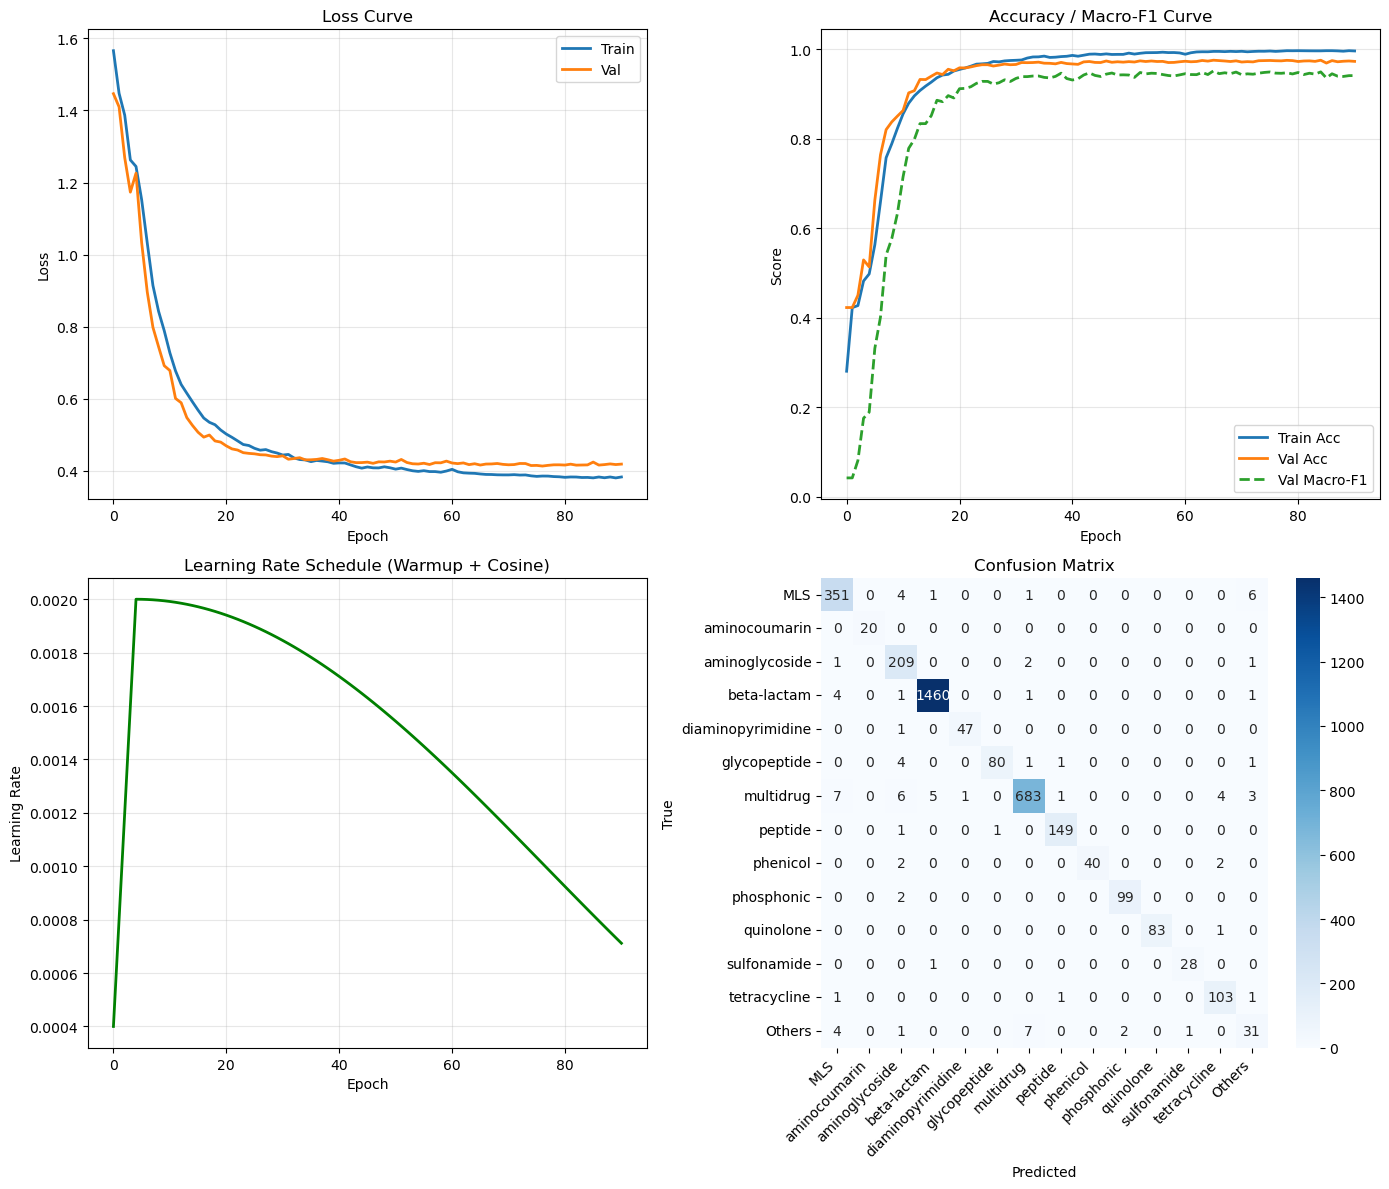

2026-02-05 13:25:27,303 - Figures saved to ./figures



Model saved to: ./well-trained/bilstm_multi_20260205_1316.pth


In [19]:
# 运行训练
model_path = train()
print(f"\nModel saved to: {model_path}")
